<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Гальцев Борис Сергеевич, @Borisgaltsev

Входные данные:  

- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.  
- target.csv (train.csv) - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).  
- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv.  
- validation_answer.csv - правильные ответы к предыдущему файлу.  

Задача:  

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv.  
- оценить качество алгоритма по метрике accuracy@5.  
- *деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.  

Задача матчинга будет решаться алгоритмом приближенного поиска ближайших соседей с помощью библиотеки FAISS.

**Загрузка и знакомства с данными**

Импорт необходимых библиотек

In [1]:
!pip install faiss-cpu

In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import faiss
import datetime as dt
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, ConfusionMatrixDisplay
from tqdm.notebook import tqdm

#from adjdatatools.preprocessing import AdjustedScaler
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler #, AdjustedScaler
from sklearn.utils import shuffle

from catboost import CatBoostClassifier
RANDOM_STATE = 12345

In [4]:
# Объявим глобальные переменные
k = 5
n_cells = 333
n_neighbours = 20

Загрузка base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

In [5]:
try:
    df_base = pd.read_csv('base.csv')
except:
    df_base = pd.read_csv('/data/base.csv', index_col=0)
df_base.head(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [6]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [7]:
# с целью экономии памяти - сменим тип на float32
for i in range(72):
    df_base[str(i)] = df_base[str(i)].astype('float32')

In [8]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


In [9]:
df_base.head(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


Загрузка target.csv (train.csv) - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

In [10]:
try:
    df_train = pd.read_csv('train.csv')
except:
    df_train = pd.read_csv('/data/train.csv', index_col=0)
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [12]:
# с целью экономии памяти - сменим тип на float32
for i in range(72):
    df_train[str(i)] = df_train[str(i)].astype('float32')

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21  

Загрузка validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv.

In [14]:
try:
    df_validation = pd.read_csv('validation.csv')
except:
    df_validation = pd.read_csv('/data/validation.csv', index_col=0)
df_validation.head(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [15]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [16]:
# с целью экономии памяти - сменим тип на float32
for i in range(72):
    df_validation[str(i)] = df_validation[str(i)].astype('float32')

In [17]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

Загрузка validation_answer.csv - правильные ответы к validation.csv.

In [18]:
try:
    df_validation_answer = pd.read_csv('validation_answer.csv')
except:
    df_validation_answer = pd.read_csv('/data/validation_answer.csv', index_col=0)
df_validation_answer.head(5)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [19]:
df_validation_answer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


Итак, по итогу загрузки:  

- **df_base** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.  
- **df_train** - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков И id товара из df_base, который максимально похож на него (по мнению экспертов).  
- **df_validation** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из df_base.  
- **df_validation_answer** - правильные ответы к df_validation.

Посмотрим на распределения данных датасетов

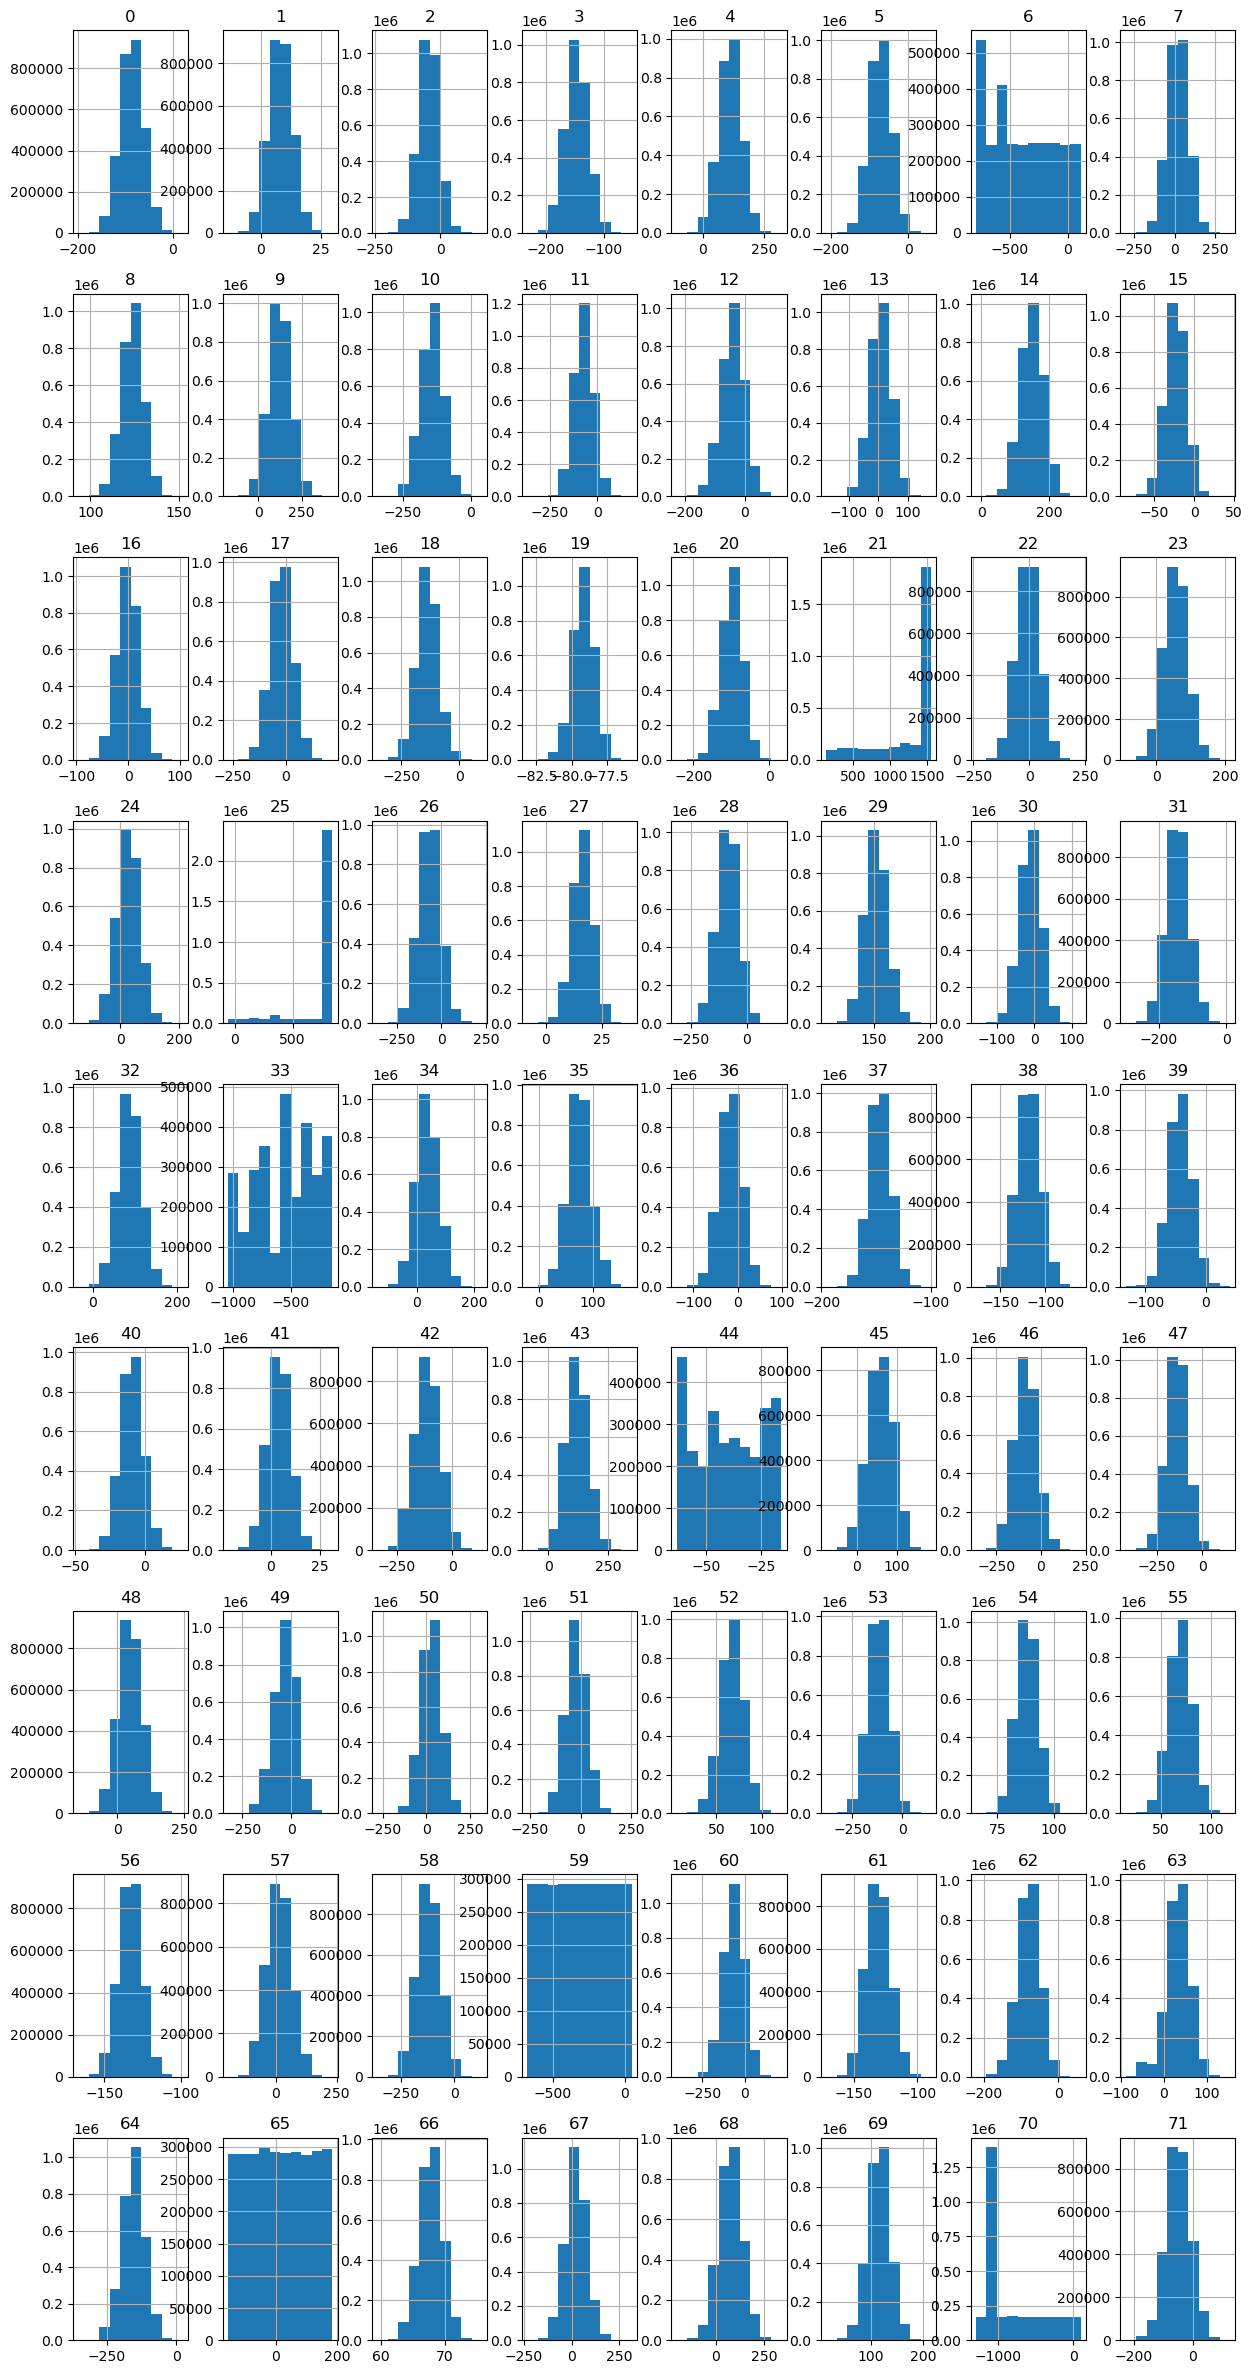

In [20]:
# df_base
df_base.hist(figsize=(15, 30));

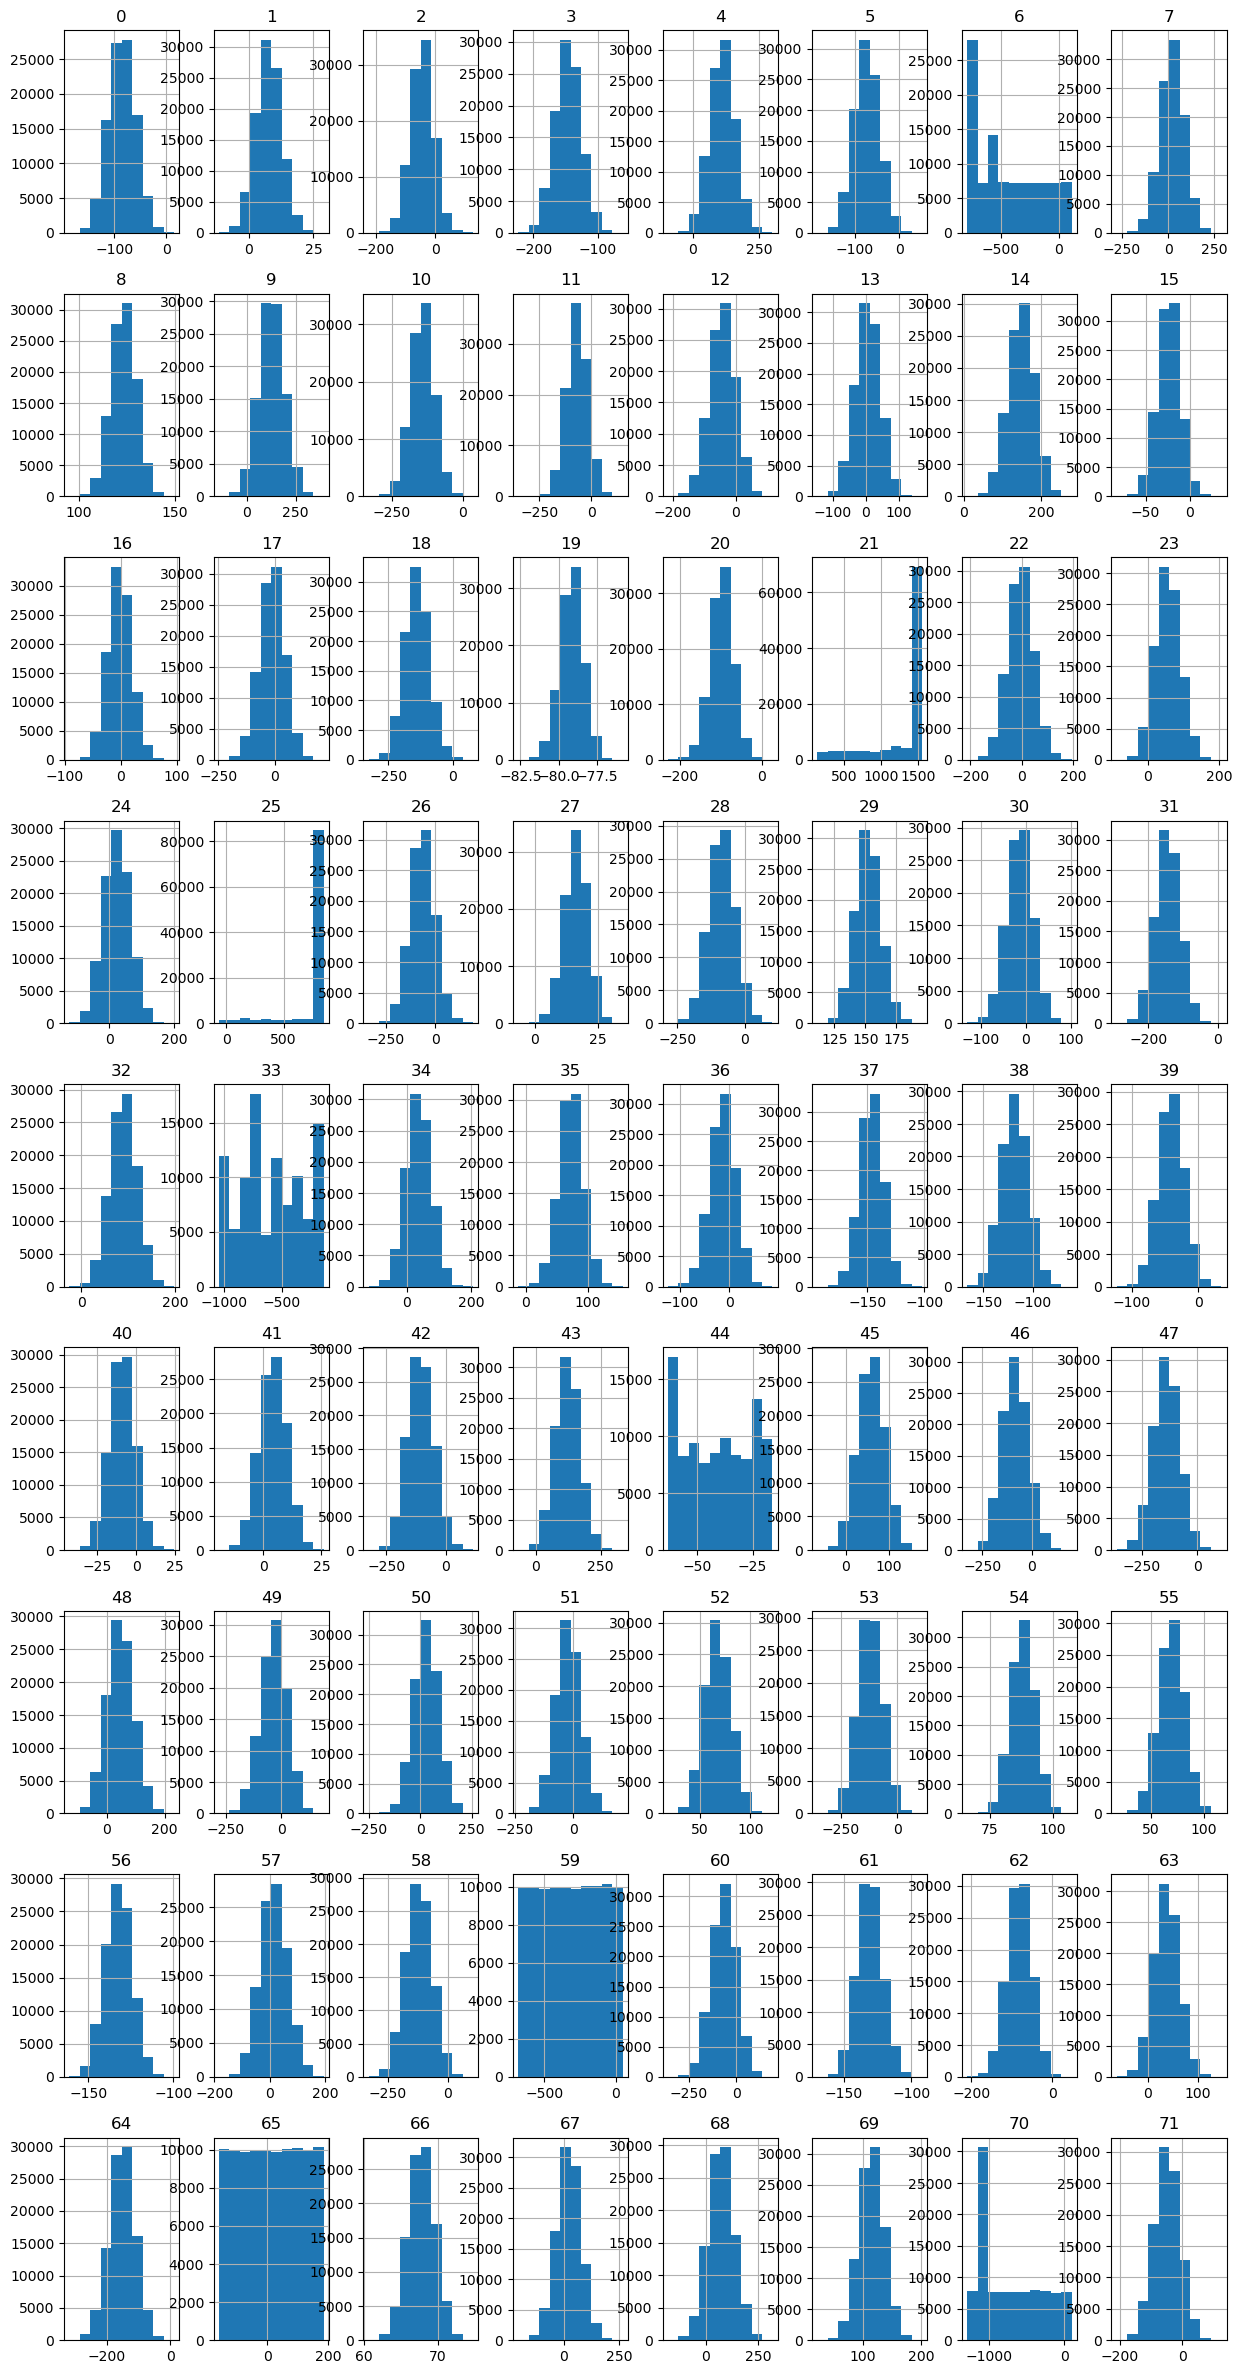

In [21]:
# df_base
df_train.hist(figsize=(15, 30));

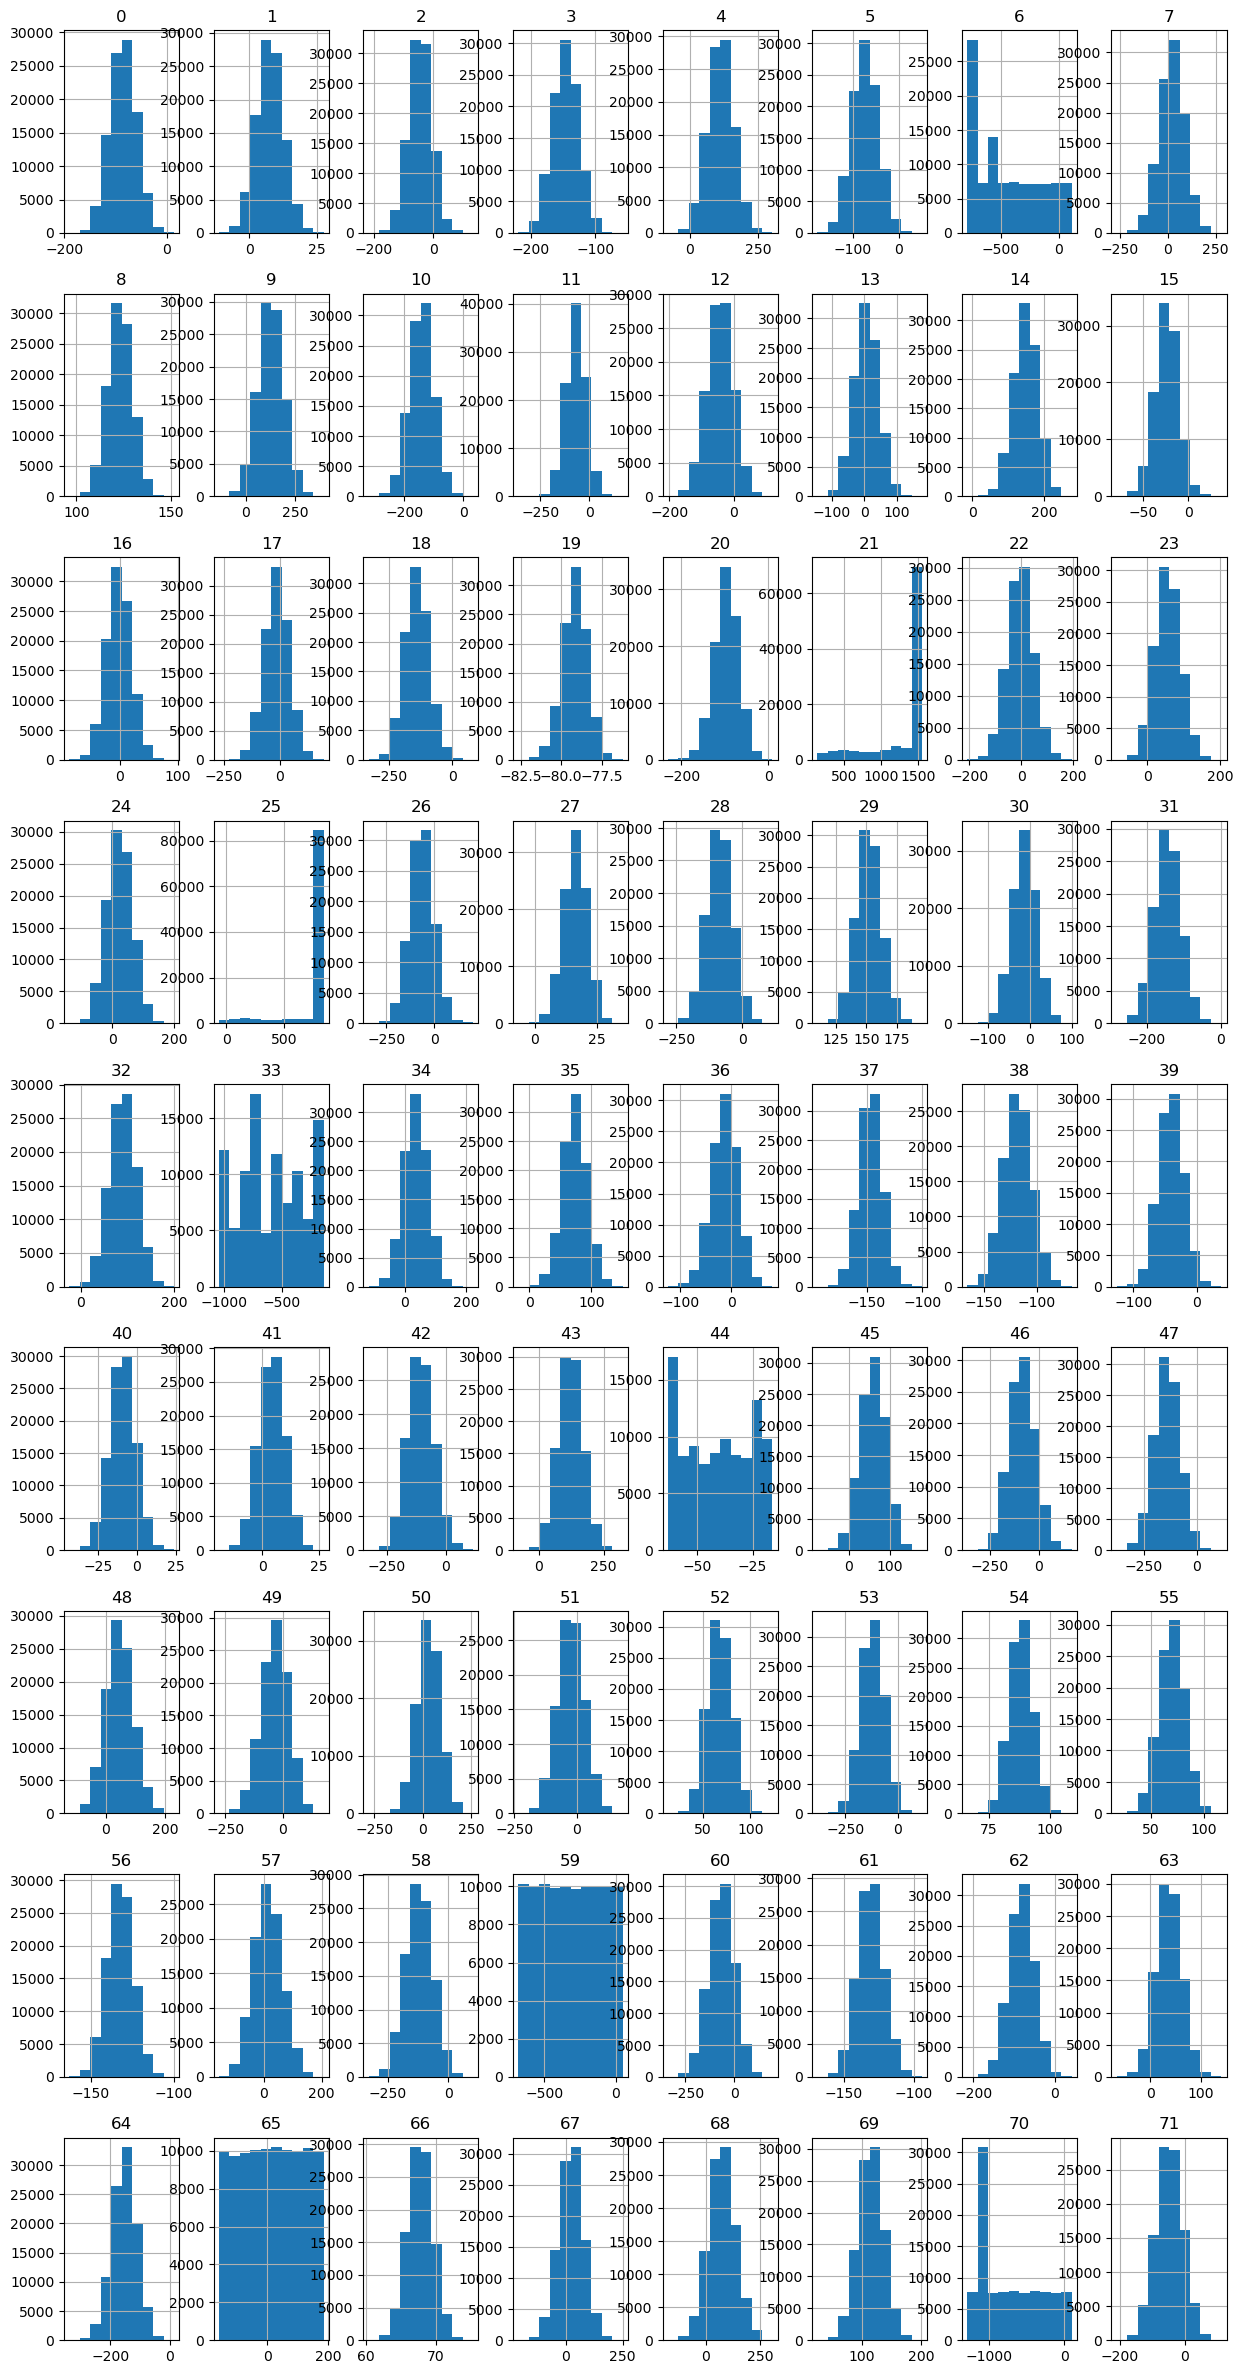

In [22]:
# df_base
df_validation.hist(figsize=(15, 30));

In [23]:
print('Количество явных дубликатов df_base', df_base.duplicated().sum())

Количество явных дубликатов df_base 0


In [24]:
print('Количество явных дубликатов df_train', df_train.duplicated().sum())

Количество явных дубликатов df_train 0


In [25]:
print('Количество явных дубликатов df_validation', df_validation.duplicated().sum())

Количество явных дубликатов df_validation 0


Посмотрим на корреляцию признаков

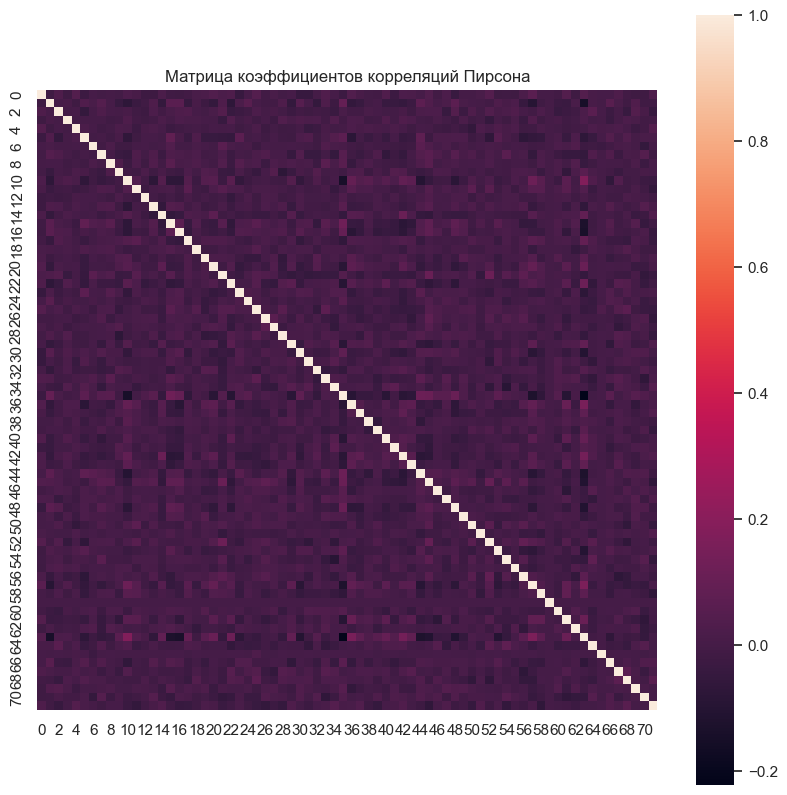

In [26]:
# Построим матрицу коэффициентов корреляций Пирсона
sns.set(rc = {'figure.figsize':(10, 10)})
sns.heatmap(df_base.corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона');

**Вывод по итогам загрузки и знакомства с данными:**    

Все три набора данных зашифрованы, данные ненормированные – диапазоны их значений отличаются. Для каждого образца товара имеется 72 характеристики, все представляют собой дробные числа (float32).  
Пропусков и дубликатов нет ни в одном наборе.

Характер распределений для каждого признака одинаков по всем трем датасетам. 64 признака имеют распределение, близкое к нормальному. В столбцах '6', '21', '25', '33', '44', '59', '60', '65' и '70' распределения признаков значительно отличаются от нормальных.

Явная зависимость между признаками - отсутствует. Всех их можно считать уникальными характеристиками товара.

**Создадим индекс**

In [27]:
dims = df_base.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [28]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [29]:
# Индекс id и номеров векторов
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

**Первоначальная оценка метрики**

In [30]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [31]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

5.535


**Нормализация данных**

место для заглушки (пометка для себя)

**RobustScaler**

In [ ]:
scaler = RobustScaler()
df_base2 = scaler.fit_transform(df_base)
df_train2 = scaler.transform(df_train)

dims = df_base2.shape[1]
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base2[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))

In [ ]:
%%time

vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

53

**StandartScaler**

In [ ]:
scaler = StandardScaler()
df_base2 = scaler.fit_transform(df_base)
df_train2 = scaler.transform(df_train)

dims = df_base2.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base2[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))

In [ ]:
%%time

vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

65.838  
Wall time: 1h 21min 3s

53.947
Wall time: 18.5 s

In [33]:
unnormal_columns = ['6', '21', '25', '33', '44', '59', '60', '65', '70']
df_base_drop = df_base.copy()
df_train_drop = df_train.copy()
df_validation_drop = df_validation.copy()

for df in [df_base_drop, df_train_drop, df_validation_drop]:
  for column in unnormal_columns:
    df.drop(column, axis=1, inplace=True)

RobustScaler_drop

In [ ]:
scaler = RobustScaler()
df_base_drop_2 = scaler.fit_transform(df_base_drop)
df_train_drop_2 = scaler.transform(df_train_drop)

dims = df_base_drop_2.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base_drop_2[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop_2).astype('float32'))

In [ ]:
%%time

vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_drop_2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

62.159  
Wall time: 17 s

StandardScaler_drop

In [34]:
scaler = StandardScaler()
df_base_drop_2 = scaler.fit_transform(df_base_drop)
df_train_drop_2 = scaler.transform(df_train_drop)
df_validation_drop_2 = scaler.transform(df_validation_drop)

dims = df_base_drop_2.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [35]:
idx_l2.train(np.ascontiguousarray(df_base_drop_2[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop_2).astype('float32'))

In [36]:
%%time

# n_neighbours = 20
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_drop_2).astype('float32'), n_neighbours)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

65.278
Wall time: 18.1 s


62.123  
Wall time: 16.4 s

На этом этапе создано и наполнено векторное пространство из объектов датасета df_base. Пространство поделено на кластеры, что ускоряет и уточняет процесс поиска. Для каждого объекта из df_train были найдены ближайшие векторы при помощи меры FlatL2. Упомянутые числовые параметры были подобраны эмпирическим путём.
Число кластеров и количество ближайших соседей подобраны экспериментальным путём, что может быть темой дальнейшего преобразования метода.  

Видим, что на данных без признаков '6', '21', '25', '33', '44', '59', '60', '65' и '70' значение метрики повышается примерно на 20%. Отбросим эти признаки и будем далее работать с масштабированными данными при помощи StandardScaler() и датафреймами df_base_drop_2, df_train_drop_2 и df_validation_drop_2. Из рассмотренных скейлеров StandardScaler() и RobustScaler() результаты примерно одинаковые, однако время вычисления у StandardScaler() значительно ниже.

Обучим модель отбирать из рекомендаций FAISS те значения товаров, которые вероятнее всего похожи на рекомендации экспертов.

**Ранжирование**

Тренировочная выборка

Составим новый датафрейм, включающий искомые векторы и векторы кандидатов на сопоставление для каждого искомого вектора.
Крайним столбцом будет 'matching', содержащий следующие значения: 1 - вектор подходит, 0 - вектор не подходим.

In [37]:
# подготовка датафрейма с перечнем ID
df_idx = pd.DataFrame(data=idx, index=df_train.index)
df_idx = pd.melt(df_idx.T)
df_idx.columns = ['id_query', 'candidate']
df_idx['id_candidate'] = [base_index[number] for number in df_idx['candidate'].values]
df_idx.drop('candidate', axis=1, inplace=True)

display(df_idx)

,id_query,id_candidate
0,0-query,361564-base
1,0-query,1375561-base
2,0-query,2515747-base
3,0-query,530165-base
4,0-query,244376-base
...,...,...
1999995,99999-query,1082569-base
1999996,99999-query,51621-base
1999997,99999-query,1701065-base
1999998,99999-query,3837592-base


Полученные колонки с id (id_query и id_candidate) товаров будут использованы для объединения при помощи метода merge(). В качестве данных будут использоваться скалированные признаки.

In [38]:
# формирование датафреймов из скалированных данных
df_base_transform  = pd.DataFrame(df_base_drop_2,  index=df_base.index)
df_train_transform = pd.DataFrame(df_train_drop_2, index=df_train.index)
df_valid_transform = pd.DataFrame(df_validation_drop_2, index=df_validation.index)

# объединение base и train по заготовленным Id
train_base_df = df_idx.merge(df_train_transform, left_on='id_query', right_on='Id', how='left')
train_base_df = train_base_df.merge(df_base_transform, left_on='id_candidate', right_on='Id', how='left', suffixes=('', '_base'))
train_base_df = train_base_df.merge(targets, left_on='id_query', right_on='Id', how='left')
display(train_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,...,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,Target
0,0-query,361564-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,0.216622,-0.332150,1.723392,-0.369458,-1.100242,0.280916,-0.492041,0.532096,0.090279,675816-base
1,0-query,1375561-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,0.144493,-0.873146,1.699855,-0.241953,-0.985258,0.009024,-0.475138,0.479393,0.371489,675816-base
2,0-query,2515747-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,-0.220597,-0.673620,1.182057,-0.393427,-1.039616,0.076838,-0.353940,0.698070,0.920024,675816-base
3,0-query,530165-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,0.235215,-0.795016,1.797431,-0.348638,-1.220347,0.203649,-0.711434,0.745986,0.805135,675816-base
4,0-query,244376-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,0.019230,-0.434846,1.927876,-0.618656,-1.117569,0.592058,-0.571596,0.614138,0.177648,675816-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,99999-query,1082569-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,...,-0.308670,1.141885,-0.782095,2.018564,-0.024619,0.767784,1.229996,-0.466265,-0.997380,2769109-base
1999996,99999-query,51621-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,...,-0.244150,0.121226,-1.235101,0.954440,0.792810,1.749656,0.257048,0.238689,-0.128593,2769109-base
1999997,99999-query,1701065-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,...,-0.504936,-0.653961,-1.154024,0.772447,-0.398981,1.410614,1.072950,0.578981,-1.168215,2769109-base
1999998,99999-query,3837592-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,...,-0.958456,-0.736506,-0.338400,0.549597,-1.009280,-1.123891,1.008035,-1.093458,-0.282381,2769109-base


In [39]:
# преобразование целевого признака для бинарной классификации (0 и 1)
train_base_df['matching'] = (train_base_df['id_candidate'] == train_base_df['Target']).astype('int')
display(train_base_df[['id_query', 'id_candidate', 'Target', 'matching']])
train_base_df.drop('Target', axis=1, inplace=True)

,id_query,id_candidate,Target,matching
0,0-query,361564-base,675816-base,0
1,0-query,1375561-base,675816-base,0
2,0-query,2515747-base,675816-base,0
3,0-query,530165-base,675816-base,0
4,0-query,244376-base,675816-base,0
...,...,...,...,...
1999995,99999-query,1082569-base,2769109-base,0
1999996,99999-query,51621-base,2769109-base,0
1999997,99999-query,1701065-base,2769109-base,0
1999998,99999-query,3837592-base,2769109-base,0


In [40]:
# выделение признаков и таргета
y_train = train_base_df['matching']
X_train = train_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_train.to_frame())
display(X_train)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
1999995,0
1999996,0
1999997,0
1999998,0


,0,1,2,3,4,5,6,7,8,9,...,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base
0,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,-1.997447,0.216622,-0.332150,1.723392,-0.369458,-1.100242,0.280916,-0.492041,0.532096,0.090279
1,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,-1.576856,0.144493,-0.873146,1.699855,-0.241953,-0.985258,0.009024,-0.475138,0.479393,0.371489
2,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,-1.567701,-0.220597,-0.673620,1.182057,-0.393427,-1.039616,0.076838,-0.353940,0.698070,0.920024
3,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,-1.795106,0.235215,-0.795016,1.797431,-0.348638,-1.220347,0.203649,-0.711434,0.745986,0.805135
4,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,-1.350794,0.019230,-0.434846,1.927876,-0.618656,-1.117569,0.592058,-0.571596,0.614138,0.177648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,-0.794043,-0.111113,...,0.331215,-0.308670,1.141885,-0.782095,2.018564,-0.024619,0.767784,1.229996,-0.466265,-0.997380
1999996,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,-0.794043,-0.111113,...,0.852339,-0.244150,0.121226,-1.235101,0.954440,0.792810,1.749656,0.257048,0.238689,-0.128593
1999997,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,-0.794043,-0.111113,...,0.430598,-0.504936,-0.653961,-1.154024,0.772447,-0.398981,1.410614,1.072950,0.578981,-1.168215
1999998,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,-0.794043,-0.111113,...,-0.060299,-0.958456,-0.736506,-0.338400,0.549597,-1.009280,-1.123891,1.008035,-1.093458,-0.282381


Сформируем валидационную выборку (аналогично предыдущему разделу "Тренировочная выборка")

In [41]:
%%time

# n_neighbours = 20
vecs, valid_idx = idx_l2.search(np.ascontiguousarray(df_validation_drop_2).astype('float32'), n_neighbours)

acc = 0
for target, el in zip(df_validation_answer['Expected'].tolist(), valid_idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(valid_idx))

65.09
Wall time: 19.5 s


In [42]:
# подготовка датафрейма с перечнем ID
df_idx = pd.DataFrame(data=valid_idx, index=df_validation.index)
df_idx = pd.melt(df_idx.T)
df_idx.columns = ['id_query', 'candidate']
df_idx['id_candidate'] = [base_index[number] for number in df_idx['candidate'].values]
df_idx.drop('candidate', axis=1, inplace=True)

display(df_idx)

,id_query,id_candidate
0,100000-query,2760762-base
1,100000-query,3209652-base
2,100000-query,1542803-base
3,100000-query,3839597-base
4,100000-query,508555-base
...,...,...
1999995,199999-query,1062424-base
1999996,199999-query,551378-base
1999997,199999-query,178603-base
1999998,199999-query,4103576-base


In [43]:
%%time
# объединение base и valid по списку ближайших соседей
valid_base_df = df_idx.merge(df_valid_transform, left_on='id_query', right_on='Id', how='left')
valid_base_df = valid_base_df.merge(df_base_transform, left_on='id_candidate', right_on='Id', how='left', suffixes=('', '_base'))
valid_base_df = valid_base_df.merge(df_validation_answer['Expected'], left_on='id_query', right_on='Id', how='left')
display(valid_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,...,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,Expected
0,100000-query,2760762-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.578071,-0.061286,0.089266,0.047589,0.533942,1.168393,-0.104937,0.162420,-1.245106,2676668-base
1,100000-query,3209652-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.929757,0.457505,0.948873,0.570802,0.909869,0.897679,0.018913,0.430446,-1.182590,2676668-base
2,100000-query,1542803-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.539853,0.112325,0.345714,0.193005,0.721656,0.610940,-0.160718,0.507207,-1.025508,2676668-base
3,100000-query,3839597-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.979324,0.247559,0.610572,-0.253008,0.633808,0.570935,-0.031723,0.628662,-1.195790,2676668-base
4,100000-query,508555-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.859637,0.304085,0.202567,0.075604,1.019881,0.701631,0.580178,0.301698,-0.860531,2676668-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,199999-query,1062424-base,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,...,-0.193072,-0.973402,-0.395288,-0.289691,0.300883,-0.433115,0.309165,0.655273,-0.449798,336472-base
1999996,199999-query,551378-base,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,...,-0.048509,-0.976296,-0.221828,-0.081177,-0.675163,-0.088747,-0.436402,1.476520,-0.419881,336472-base
1999997,199999-query,178603-base,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,...,-0.415714,-0.730400,0.544716,-0.687963,-0.715001,0.140402,1.082257,0.497674,0.328189,336472-base
1999998,199999-query,4103576-base,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,...,-0.199678,-0.204557,-0.043598,-0.563210,0.426331,-0.207629,0.939288,0.923227,0.111965,336472-base


Wall time: 18.8 s


In [44]:
# преобразование целевого признака для бинарной классификации (0 и 1)
valid_base_df['matching'] = (valid_base_df['id_candidate'] == valid_base_df['Expected']).astype('int')
display(valid_base_df[['id_query', 'id_candidate', 'Expected', 'matching']])
valid_base_df.drop('Expected', axis=1, inplace=True)

,id_query,id_candidate,Expected,matching
0,100000-query,2760762-base,2676668-base,0
1,100000-query,3209652-base,2676668-base,0
2,100000-query,1542803-base,2676668-base,0
3,100000-query,3839597-base,2676668-base,0
4,100000-query,508555-base,2676668-base,0
...,...,...,...,...
1999995,199999-query,1062424-base,336472-base,0
1999996,199999-query,551378-base,336472-base,0
1999997,199999-query,178603-base,336472-base,0
1999998,199999-query,4103576-base,336472-base,0


In [45]:
# выделение признаков и таргета
y_valid = valid_base_df['matching']
X_valid = valid_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_valid.to_frame())
display(X_valid)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
1999995,0
1999996,0
1999997,0
1999998,0


,0,1,2,3,4,5,6,7,8,9,...,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,0.322683,-1.578071,-0.061286,0.089266,0.047589,0.533942,1.168393,-0.104937,0.162420,-1.245106
1,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,-0.647153,-1.929757,0.457505,0.948873,0.570802,0.909869,0.897679,0.018913,0.430446,-1.182590
2,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,-0.555441,-1.539853,0.112325,0.345714,0.193005,0.721656,0.610940,-0.160718,0.507207,-1.025508
3,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,-0.417542,-1.979324,0.247559,0.610572,-0.253008,0.633808,0.570935,-0.031723,0.628662,-1.195790
4,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,-0.124973,-1.859637,0.304085,0.202567,0.075604,1.019881,0.701631,0.580178,0.301698,-0.860531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,-0.714217,-0.193072,-0.973402,-0.395288,-0.289691,0.300883,-0.433115,0.309165,0.655273,-0.449798
1999996,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,-1.101371,-0.048509,-0.976296,-0.221828,-0.081177,-0.675163,-0.088747,-0.436402,1.476520,-0.419881
1999997,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,-2.141862,-0.415714,-0.730400,0.544716,-0.687963,-0.715001,0.140402,1.082257,0.497674,0.328189
1999998,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,-0.568166,-0.199678,-0.204557,-0.043598,-0.563210,0.426331,-0.207629,0.939288,0.923227,0.111965


Логистическая регрессия

Попробуем Логистическую регрессию.

In [46]:
%%time

model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train, y_train)

valid_predictions = model.predict(X_valid)
valid_probabilities = model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, valid_predictions)

print('valid_accuracy: {:.2%}'.format(valid_accuracy))

valid_accuracy: 58.03%
Wall time: 26.6 s


In [47]:
# Выбор 5 лучших кандидатов
valid_proba_series = pd.Series(valid_probabilities)
valid_candidates = []
for i in range(0, len(valid_proba_series), n_neighbours):
    query = valid_proba_series[i : i+n_neighbours]
    index = query.sort_values(ascending=False)[0:k].index
    valid_candidates.append(index)

In [48]:
# accuracy@5
acc = 0
for target, el in zip(df_validation_answer['Expected'].tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[el, 'id_candidate'].values)

print('accuracy@5: ', 100 * acc / len(valid_candidates))

accuracy@5:  22.956


Посмотрим на CatBoostClassifier

In [49]:
model = CatBoostClassifier(auto_class_weights = 'Balanced', verbose=50)

In [50]:
# обучаем модель
model.fit(X_train, y_train)

Learning rate set to 0.264529
0:	learn: 0.6636194	total: 1.23s	remaining: 20m 27s
50:	learn: 0.3486791	total: 53.2s	remaining: 16m 30s
100:	learn: 0.3158324	total: 1m 38s	remaining: 14m 34s
150:	learn: 0.2955513	total: 2m 23s	remaining: 13m 26s
200:	learn: 0.2812585	total: 3m 7s	remaining: 12m 24s
250:	learn: 0.2688899	total: 3m 52s	remaining: 11m 35s
300:	learn: 0.2582019	total: 4m 35s	remaining: 10m 40s
350:	learn: 0.2486616	total: 5m 19s	remaining: 9m 50s
400:	learn: 0.2397029	total: 6m 3s	remaining: 9m 2s
450:	learn: 0.2311557	total: 6m 47s	remaining: 8m 15s
500:	learn: 0.2236895	total: 7m 29s	remaining: 7m 27s
550:	learn: 0.2167739	total: 8m 12s	remaining: 6m 41s
600:	learn: 0.2099006	total: 8m 55s	remaining: 5m 55s
650:	learn: 0.2037327	total: 9m 38s	remaining: 5m 10s
700:	learn: 0.1977882	total: 10m 22s	remaining: 4m 25s
750:	learn: 0.1924098	total: 11m 5s	remaining: 3m 40s
800:	learn: 0.1870982	total: 11m 48s	remaining: 2m 56s
850:	learn: 0.1819207	total: 12m 31s	remaining: 2m 

In [51]:
valid_predictions = model.predict(X_valid)
valid_probabilities = model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, valid_predictions)

print('valid_accuracy: {:.2%}'.format(valid_accuracy))

valid_accuracy: 92.32%


In [52]:
# Выбор 5 лучших кандидатов
valid_proba_series = pd.Series(valid_probabilities)
valid_candidates = []
for i in range(0, len(valid_proba_series), n_neighbours):
    query = valid_proba_series[i : i+n_neighbours]
    index = query.sort_values(ascending=False)[0:k].index
    valid_candidates.append(index)

In [53]:
# accuracy@5
acc = 0
for target, el in zip(df_validation_answer['Expected'].tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[el, 'id_candidate'].values)

print('accuracy@5: ', 100 * acc / len(valid_candidates))

accuracy@5:  60.865


accuracy@5:  60.865

Вывод:  

Все наборы исходных данных имеют хорошее качество. Пропуски, дубликаты, выбросы и аномалии отсутствуют. 

Данные зашифрованы, данные ненормированные – диапазоны их значений отличаются. 
Для каждого образца товара имеется 72 характеристики, все представляют собой дробные числа (изначально float64).

Характер распределений для каждого признака одинаков по всем трем датасетам. 64 признака имеют распределение, близкое к нормальному. В столбцах '6', '21', '25', '33', '44', '59', '60', '65' и '70' распределения признаков значительно отличаются от нормальных.

Явная зависимость между признаками - отсутствует. Всех их можно считать уникальными характеристиками товара.

Поскольку значения признаков в датасетах сильно отличались друг от друга, было применено масштабирование, опытным путем был выбран StandardScaler, показавший лучшую скорость работы алгоритма и метрики acc@5. Масштабирование помогло достигнуть одного диапазона значений признаков и далее находить объективные закономерности.

Было создано и наполнено векторное пространство из объектов датасета df_base. Пространство поделено на кластеры, что ускорило и увеличило точность процесса поиска. Для каждого объекта из df_train были найдены ближайшие векторы при помощи меры FlatL2. Числовые параметры кластеров и ближайших векторов были подобраны опытным путем.

Далее, среди найденных кандидатов были выделены пятерки самых подходящий. Для этого их применялась Логистическая регрессия и CatBoost. Эффект дисбаланса классов был уменьшен с помощью штатного гиперпараметра модели class_weight, тем самым назначив разные веса для классов.

Лучшее итоговое значение целевой метрики составило 60.865% на CatBoost.

Времени не хватило на изучение всего того, что было дано на встречах, проект очень интересный, есть желание дальше дорабатывать, но в силу установленных конкретных сроков сдачи на данный момент сдаю текущую версию.